In [57]:
from gwpy.timeseries import TimeSeries
from scipy.signal import coherence
import cdsutils
import matplotlib.pyplot as plt

In [58]:
def fetch_timeseries_data(channel, gps_start, gps_end, mode):
    if mode == 'gwpy':
        #data = TimeSeries.fetch(channel, gps_start, gps_end,connection=conn, allow_tape=True)
        data = TimeSeries.fetch(channel, gps_start, gps_end,allow_tape=True)
    elif mode == 'cdsutils':
        target_data =  cdsutils.getdata(channel, gps_end-gps_start, gps_start)
        print(target_data)
        data = TimeSeries(data=target_data.data, t0=gps_start, dt=1/target_data.sample_rate,name=channel)
    return data


def coherence_calculator(data_A, data_B):
    rate = data_A.sample_rate.value
    f,coh = coherence(data_A.value,data_B.value, fs=rate, nperseg=rate*512, noverlap=rate*512/2)
    return f,coh


def plot_asd_coherence(data_A, data_B):

    f,coh = coherence_calculator(data_A, data_B)
    ax1 = plt.subplot(211)
    asd_a = ITMX_data.asd(fftlength=512,overlap=0.5)
    asd_b = ITMY_data.asd(fftlength=512,overlap=0.5)
    ax1.plot(asd_a.frequencies, asd_a.value, label="ITMX")
    ax1.plot(asd_b.frequencies, asd_b.value, label="ITMY")
    ax1.set_xlim(0.001,100)
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.legend()
    ax2 = plt.subplot(212,sharex=ax1)
    ax2.plot(f,coh)
    plt.show()

In [59]:
# Checking coherence between ETMX and ITMX ground sensors

ITMX_data = fetch_timeseries_data('L1:ISI-GND_STS_ITMX_X_DQ',
                                  1399750000, 1399750000 + 10*512, "cdsutils" )
ITMY_data = fetch_timeseries_data('L1:ISI-GND_STS_ITMY_X_DQ',
                                  1399750000, 1399750000 + 10*512, "cdsutils" )

<CDSData L1:ISI-GND_STS_ITMX_X_DQ (GPS start: 1399750000, Fs: 512.0, 2378240 samples)>
<CDSData L1:ISI-GND_STS_ITMY_X_DQ (GPS start: 1399750000, Fs: 512.0, 2381312 samples)>


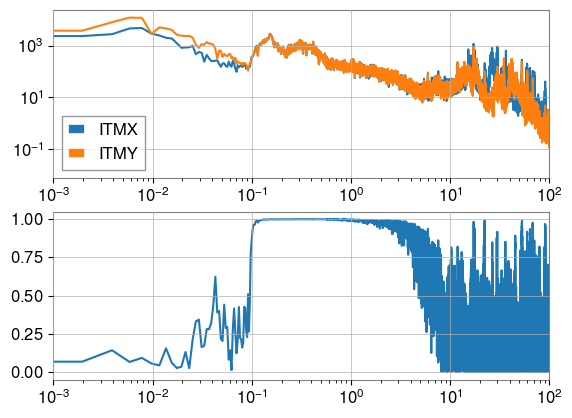

In [60]:
plot_asd_coherence(ITMX_data, ITMY_data)

In [61]:
f,coh = coherence_calculator(ITMX_data, ITMY_data)

In [62]:
from gwpy.frequencyseries import FrequencySeries
import numpy as np
asd_a = ITMX_data.asd(fftlength=512,overlap=0.5)
asd_b = ITMY_data.asd(fftlength=512,overlap=0.5)
asd_dis_a = FrequencySeries(data=asd_a.value/(2*np.pi*asd_a.frequencies), 
                            f0=asd_a.f0, 
                            df=asd_a.df, 
                            name=asd_a.name, 
                            epoch=asd_a.epoch, 
                            channel=asd_a.channel)

asd_dis_b = FrequencySeries(data=asd_b.value/(2*np.pi*asd_b.frequencies), 
                            f0=asd_b.f0, 
                            df=asd_b.df, 
                            name=asd_b.name, 
                            epoch=asd_b.epoch, 
                            channel=asd_b.channel)

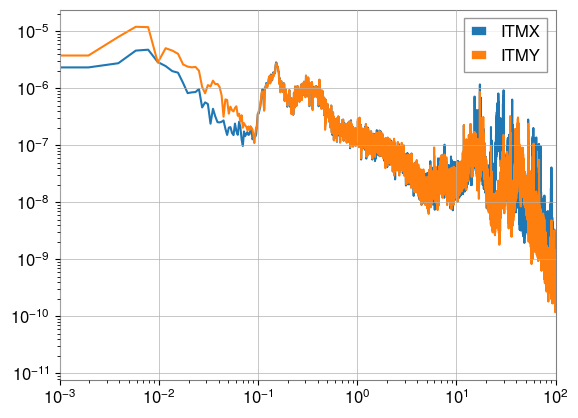

In [63]:
import matplotlib.pyplot as plt
plt.plot(asd_a.frequencies, asd_a.value*1e-9, label="ITMX")
plt.plot(asd_b.frequencies, asd_b.value*1e-9, label="ITMY")
plt.xlim(0.001,100)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

In [64]:
asd_a.frequencies

<Index [0.00000000e+00, 1.95312500e-03, 3.90625000e-03, ...,
        2.55996094e+02, 2.55998047e+02, 2.56000000e+02] Hz>

In [65]:
def noise_model(f, a, b, na, nb):
    """Noise model"""

    noise = ((na/f**a)**2 + (nb/f**b)**2)**.5
    return noise
n_sei_x = noise_model(asd_a.frequencies.value, a=1.95, b=1.1, na=10**-9, nb=0)    
n_sei_y = noise_model(asd_a.frequencies.value, a=1.95, b=1.1, na=10**-9, nb=0)

/tmp/ipykernel_1358725/4189014789.py:4: RuntimeWarning: divide by zero encountered in divide
  noise = ((na/f**a)**2 + (nb/f**b)**2)**.5
/tmp/ipykernel_1358725/4189014789.py:4: RuntimeWarning: invalid value encountered in divide
  noise = ((na/f**a)**2 + (nb/f**b)**2)**.5


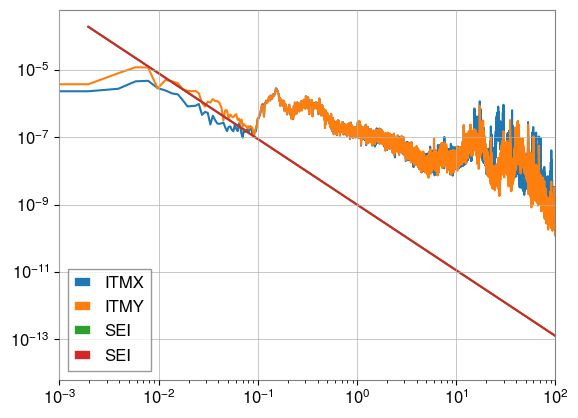

In [66]:
plt.plot(asd_a.frequencies, asd_a.value*1e-9, label="ITMX")
plt.plot(asd_b.frequencies, asd_b.value*1e-9, label="ITMY")
plt.plot(asd_a.frequencies, n_sei_y, label="SEI")
plt.plot(asd_a.frequencies, n_sei_x, label="SEI")
plt.xlim(0.001,100)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

In [67]:
from scipy.signal import argrelextrema

f,coh = coherence_calculator(ITMX_data, ITMY_data)
# find the point where there is max coherence
rounded_coh = np.round(coh, 2)
first_one_coh = np.min(np.where(rounded_coh == 1.00))
last_half_coh = np.max(np.where((rounded_coh[0:first_one_coh] - 0.5) < 0.01))
min_vals = argrelextrema(asd_dis_a.value[0:first_one_coh], np.less)[0]
closest_val = np.min(np.where(np.abs(min_vals - last_half_coh) < 5))
frequency = asd_dis_a.frequencies[min_vals[closest_val]]


In [68]:
def plot_asd_coherence(data_A, data_B, cutoff_freq=None):

    f,coh = coherence_calculator(data_A, data_B)
    fig, (ax1,ax2) = plt.subplots(2,1, sharex=True, figsize=(15,6))
    asd_a = data_A.asd(fftlength=512,overlap=0.5)
    asd_b = data_B.asd(fftlength=512,overlap=0.5)
    asd_a_dis = asd_a.value/(2*np.pi*asd_a.frequencies)
    asd_b_dis = asd_b.value/(2*np.pi*asd_b.frequencies)
    ax1.plot(asd_a.frequencies, asd_a_dis, label="ITMX")
    ax1.plot(asd_b.frequencies, asd_b_dis, label="ITMY")
    ax1.set_xlim(0.001,100)
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_title("ASD")
    if cutoff_freq:
        ax1.axvline(cutoff_freq, c='r')
    ax1.legend()
    ax2.plot(f,coh)
    ax2.set_title("Coherence")
    if cutoff_freq:
        ax2.axvline(cutoff_freq, c='r')
    plt.show()

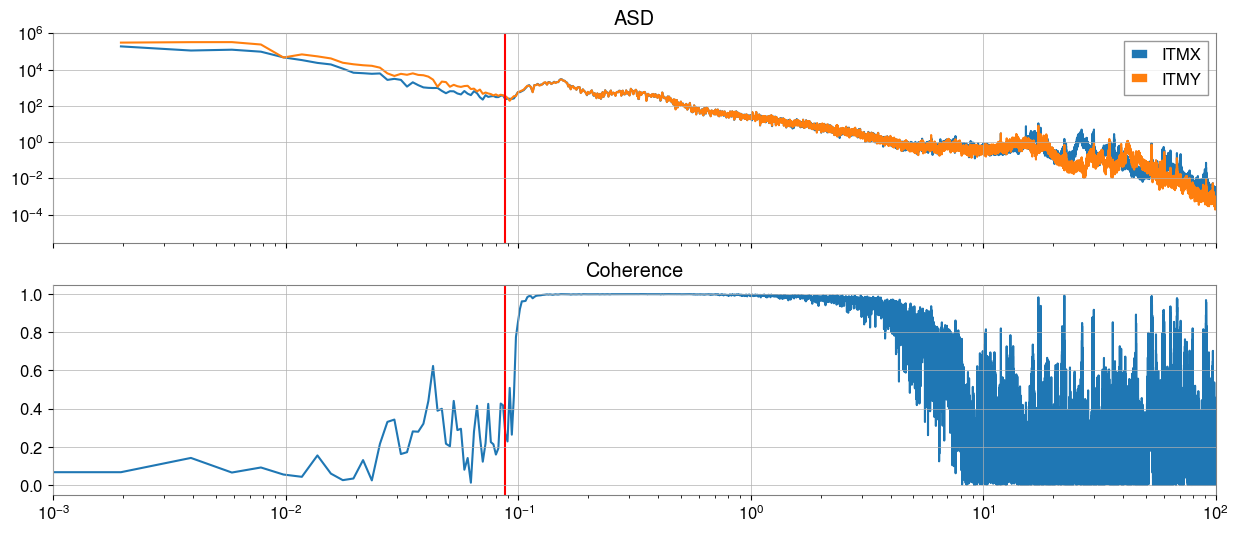

In [69]:
plot_asd_coherence(ITMX_data, ITMY_data, cutoff_freq=frequency.value)

In [70]:
min_freq = frequency_minima_scipy_groundmotion(ITMX_data, ITMY_data, asd_dis_a, asd_dis_b)

NameError: name 'frequency_minima_scipy_groundmotion' is not defined

In [ ]:
print(min_freq)

upper = np.max(np.where(asd_dis_a.frequencies.value == min_freq))
lower = np.max(np.where((asd_dis_a.frequencies.value - 1e-2) <0.001))
asd_a.frequencies[lower:upper]

In [ ]:
plt.plot(asd_dis_a.frequencies[lower:upper], asd_a.value[lower:upper]*1e-9, label="ITMX")
plt.plot(asd_dis_bb.frequencies[lower:upper], asd_b.value[lower:upper]*1e-9, label="ITMY")
plt.plot(asd_a.frequencies[lower:upper], n_sei_y[lower:upper], label="SEI")
# plt.plot(asd_a.frequencies[lower:upper], n_sei_x[lower:upper], label="SEI")
plt.xlim(0.001,100)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

In [ ]:
def noise_model(f, a, na):
    """Noise model"""

    noise = ((na/f**a)**2)**.5
    return noise

In [ ]:
from scipy.optimize import curve_fit
param, param_cov = curve_fit(noise_model, asd_dis_a.frequencies[lower:upper],asd_dis_a.value[lower:upper]*1e-9)
print(param)

In [ ]:
n_sei_x = noise_model(asd_dis_a.frequencies.value, a=param[0], na=param[1])

In [ ]:
plt.plot(asd_dis_a.frequencies, asd_dis_a.value*1e-9, label="ITMX")
plt.plot(asd_dis_b.frequencies, asd_dis_b.value*1e-9, label="ITMY")
plt.plot(asd_dis_a.frequencies, n_sei_x, label="SEI")
plt.xlim(0.001,100)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

In [ ]:
import vishack


In [ ]:
data = vishack.data.diaggui.Diaggui("etc/data/seismic_injection_data_20231210.xml")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

data = vishack.data.diaggui.Diaggui("etc/data/seismic_injection_data_20231210.xml")
f, psd = data.psd("L1:ISI-GND_STS_ITMY_Y_DQ")
psd = psd* 1/(2*np.pi*f)*1e-9
minimum = min(psd[0:100])
print(np.where(psd == minimum))

cutoff = 40

plt.loglog(f, psd)